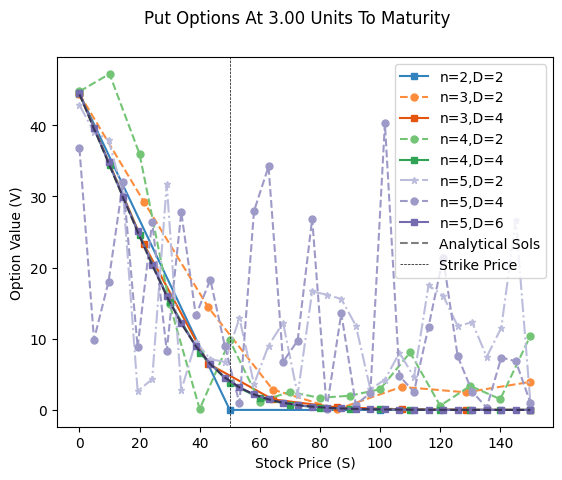

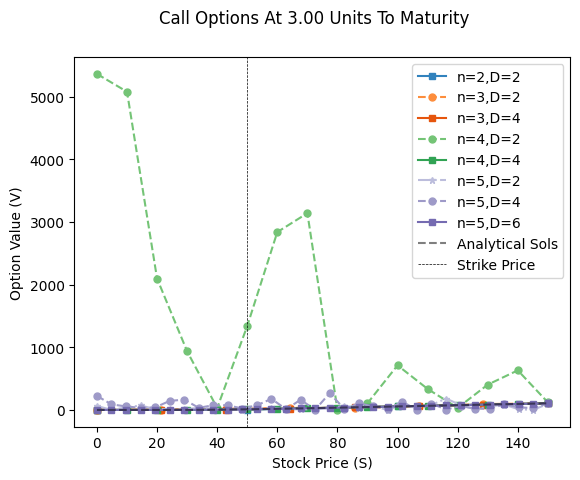

In [61]:
import h5py
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl

data_path = 'data/black_scholes/'

# styles = ['--', 'solid']
colors = list(map(plt.cm.tab20c, range(20)))
markers = 'so*'
styles = ['solid', 'dashed', 'dashdot']

for option_type in ['put','call']:
    for n in [2,3,4,5]:
        N = 2**n
        with h5py.File(f'{data_path}{option_type}_{n}_qubits.hdf5') as file:
            qnute_sols = file['rescaled_qnute_sols'][:]
            analytical_sols = file['analytical_sols'][:]
            Smin   = file.attrs['Smin']
            Smax   = file.attrs['Smax']
            T      = file.attrs['T']
            r      = file.attrs['r']
            q      = file.attrs['q']
            sigma  = file.attrs['sigma']
            strike = file.attrs['strike']
            Nt     = file.attrs['Nt']
        for Di,D in enumerate(np.arange(2,n+2,2)):
            # if option_type == 'call' and n == 4 and D == 2:
            #     continue
            # plt.plot(np.linspace(Smin,Smax,N), (sol:=qnute_sols[Di,-1,:])/np.linalg.norm(sol), label=f'{n=},{D=}')
            plt.plot(np.linspace(Smin,Smax,N), (sol:=qnute_sols[Di,-1,:]), 
                     label=f'{n=},{D=}', 
                     color=colors[(n-2)*4 + ( o_index:=((n+1)//2 - Di - 1) )],
                     marker=markers[o_index],
                     linestyle=styles[o_index],
                     ms=5)
    # plt.plot(np.linspace(Smin,Smax,N),(sol:=analytical_sols[-1,:])/np.linalg.norm(sol),label='Analytical Sols')
    plt.plot(np.linspace(Smin,Smax,N),(sol:=analytical_sols[-1,:]),label='Analytical Sols',color='k',linestyle='--',alpha=0.5)
    plt.axvline(x=strike, linewidth=0.5, linestyle='--', color='k', label='Strike Price')
    plt.suptitle(f'{option_type.capitalize()} options at {T:0.2f} units to maturity'.title())
    plt.xlabel('Stock Price (S)')
    plt.ylabel('Option Value (V)')
    plt.legend()
    plt.show()

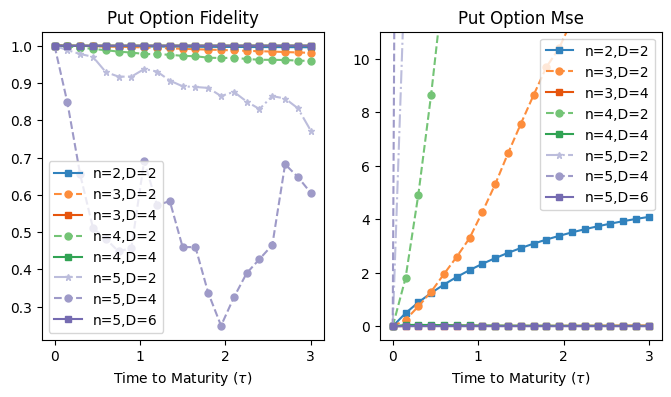

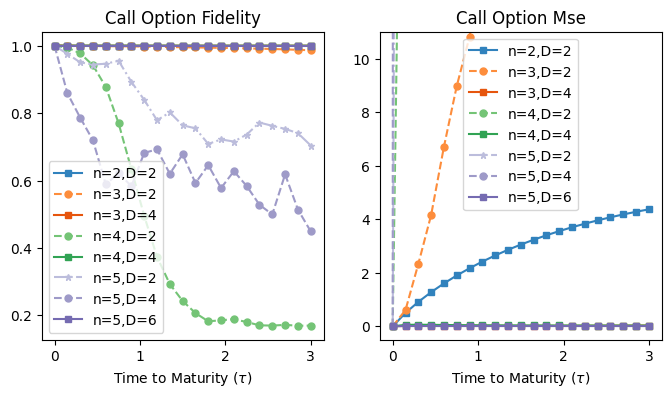

In [73]:
for option_type in ['put','call']:
    fig,axs = plt.subplots(1,2, figsize=(8,4))
    for n in [2,3,4,5]:
        N = 2**n
        with h5py.File(f'{data_path}{option_type}_{n}_qubits.hdf5') as file:
            qnute_sols = file['rescaled_qnute_sols'][:]
            analytical_sols = file['analytical_sols'][:]
            Smin   = file.attrs['Smin']
            Smax   = file.attrs['Smax']
            T      = file.attrs['T']
            r      = file.attrs['r']
            q      = file.attrs['q']
            sigma  = file.attrs['sigma']
            strike = file.attrs['strike']
            Nt     = file.attrs['Nt']
        dt = T/Nt
        fid = np.zeros((int(np.ceil(n/2)), Nt+1), np.float64)
        mse = np.zeros((int(np.ceil(n/2)), Nt+1), np.float64)
        for Di,D in enumerate(np.arange(2,n+2,2)):
            # if option_type == 'call' and n==4 and D==2:
            #     continue
            for ti in np.arange(Nt+1):
                t = ti*dt
                fid[Di,ti] = np.dot(qnute_sols[Di,ti,:],analytical_sols[ti,:])/(np.linalg.norm(qnute_sols[Di,ti,:]) * np.linalg.norm(analytical_sols[ti,:]))
                mse[Di,ti] = np.mean((qnute_sols[Di,ti,:] - analytical_sols[ti,:])**2)
            # if fid[Di,-1] < 0.7:
            #     continue
            axs[0].plot(np.arange(0,Nt+1,skip:=50)*dt, fid[Di,::skip], label=f'{n=},{D=}', 
                        color=colors[(n-2)*4 + (o_index:=(n+1)//2 - Di - 1)],
                        marker=markers[o_index],
                        linestyle=styles[o_index],
                        ms=5)
            axs[1].plot(np.arange(0,Nt+1,skip)*dt, mse[Di,::skip], label=f'{n=},{D=}',
                        color=colors[(n-2)*4 + o_index],
                        marker=markers[o_index],
                        linestyle=styles[o_index],
                        ms=5)

    axs[0].set_title(f'{option_type} option fidelity'.title() )
    axs[1].set_title(f'{option_type} option MSE'.title() )
    axs[1].set_ylim([-0.5,11])
    for ax in axs.flatten():
        ax.legend()
        ax.set_xlabel('Time to Maturity ($\\tau$)')
    plt.show()

In [47]:
for n in [2,3,4,5]:
    for Di,D in enumerate(np.arange(2,n+2,2)):
        print(f'{n}|{D}|{Di}|{(n+1)//2 - Di - 1}')

2|2|0|0
3|2|0|1
3|4|1|0
4|2|0|1
4|4|1|0
5|2|0|2
5|4|1|1
5|6|2|0
